In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

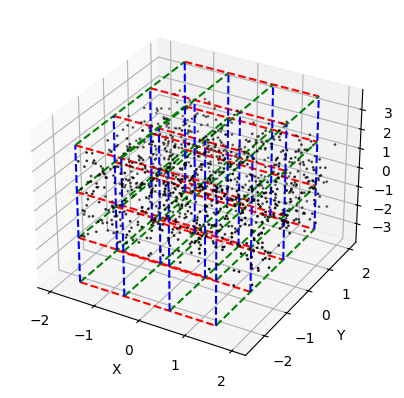

In [2]:
N_realisation =0
np.random.seed(N_realisation)
N0_particle = 10 ** 3

XP0 = np.random.uniform(-2, 2, N0_particle) 
YP0 = np.random.uniform(-2, 2, N0_particle)
ZP0 = np.random.uniform(-2, 2, N0_particle)

St0 = 0.25
R0 = 1

xl, xr = -2, 2
yl, yr = -3, 3
zd, zu = -4, 4

dx_col, dy_col, dz_col = 1, 1, 1
Nx_col, Ny_col, Nz_col = 4, 4, 4
gridA_xc, gridA_yc, gridA_zc = np.meshgrid(np.linspace(xl+dx_col/2, xr-dx_col/2, Nx_col), 
                                           np.linspace(yl+dy_col/2, yr-dy_col, Ny_col), 
                                           np.linspace(zd+dz_col/2, zu-dz_col/2, Nz_col), indexing='ij')
gridB_xc, gridB_yc, gridB_zc = np.meshgrid(np.linspace(xl, xr, Nx_col+1), np.linspace(yl, yr, Ny_col+1), np.linspace(zd, zu, Nz_col+1), indexing='ij')

# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot lines along x-axis
for i in range(Ny_col):
    for j in range(Nz_col):
        ax.plot(gridA_xc[:, i, j], gridA_yc[:, i, j], gridA_zc[:, i, j], color='r',linestyle='--')

# Plot lines along y-axis
for i in range(Nx_col):
    for j in range(Nz_col):
        ax.plot(gridA_xc[i, :, j], gridA_yc[i, :, j], gridA_zc[i, :, j], color='g',linestyle='--')


# Plot lines along z-axis
for i in range(Nx_col):
    for j in range(Ny_col):
        ax.plot(gridA_xc[i, j, :], gridA_yc[i, j, :], gridA_zc[i, j, :], color='b',linestyle='--')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(XP0, YP0, ZP0,s=1, c='k', marker='o')


plt.show()

initiate the bubble DF

In [3]:
Bubbles_df_ini = np.zeros((N0_particle, 15), dtype=np.float64)

# first column is bubbles ID
Bubbles_df_ini[:, 0] = np.arange(N0_particle)

# second column is bubbles X position
Bubbles_df_ini[:, 1] = XP0.flatten().astype(float)

# third column is bubbles Y position   
Bubbles_df_ini[:, 2] = YP0.flatten().astype(float)

# fourth column is bubbles Z position
Bubbles_df_ini[:, 3] = ZP0.flatten().astype(float)

# fourth column is bubbles x-velocity
Bubbles_df_ini[:, 4] = np.zeros(N0_particle)

# fifth column is bubbles y-velocity
Bubbles_df_ini[:, 5] = np.zeros(N0_particle)

# sixth column is bubbles z-velocity
Bubbles_df_ini[:, 6] = np.zeros(N0_particle)

# sixth column is bubbles Stokes number
Bubbles_df_ini[:, 7] = St0

# seventh column is bubbles slaved status
Bubbles_df_ini[:, 8] = False

# eighth column is bubbles gridA x-index
Bubbles_df_ini[:, 9] = np.floor((Bubbles_df_ini[:, 1] - xl ) / dx_col).astype(int)

# ninth column is bubbles gridA y-index
Bubbles_df_ini[:, 10] = np.floor((Bubbles_df_ini[:, 2] - yl ) / dy_col).astype(int)

# tenth column is bubbles gridA z-index
Bubbles_df_ini[:, 11] = np.floor((Bubbles_df_ini[:, 3] - zd ) / dz_col).astype(int)

# tenth column is bubbles gridB x-index
Bubbles_df_ini[:, 12] = np.floor((Bubbles_df_ini[:, 1]- xl + dx_col / 2) / dx_col).astype(int)

# eleventh column is bubbles gridB y-index	
Bubbles_df_ini[:, 13] = np.floor((Bubbles_df_ini[:, 2]- yl + dy_col / 2) / dy_col).astype(int)

# twelfth column is bubbles gridB z-index
Bubbles_df_ini[:, 14] = np.floor((Bubbles_df_ini[:, 3]- zd + dz_col / 2) / dz_col).astype(int)

# ditch the ones about to leave the domain 
Bubbles_df_ini = Bubbles_df_ini[(Bubbles_df_ini[:, 1] >= xl) & (Bubbles_df_ini[:, 1] < xr) 
                                & (Bubbles_df_ini[:, 2] >= yl) & (Bubbles_df_ini[:, 2] < yr)
                                & (Bubbles_df_ini[:, 3] >= zd) & (Bubbles_df_ini[:, 3] < zu)]

Feeding Bubbles from upstream reservoir

Text(0.5, 0, 'Z')

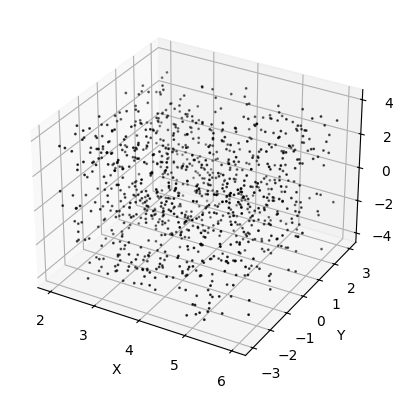

In [4]:
x_far = 6
x_res = np.linspace(xr, x_far, 100)
y_res = np.linspace(yl, yr, 100)
z_res = np.linspace(zd, zu, 100)
X_res, Y_res, Z_res = np.meshgrid(x_res, y_res, z_res)
# X_res, Y_res = np.meshgrid(x_res, y_res)

N0_particle_res = 10**3

# np.random.seed(N_realisation)
XP0_res = np.random.uniform(xr, x_far, N0_particle_res)
YP0_res = np.random.uniform(yl, yr, N0_particle_res)
ZP0_res = np.random.uniform(zd, zu, N0_particle_res)
St0_res = St0


# Plot grid lines
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XP0_res, YP0_res, ZP0_res, s=1, c='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

Build a df from reservoir bubbles to track their Lagrangian trajectories \
All reservoir bubbles are released from rest and get advected by background flows


In [5]:
Res_df_ini_0 = np.zeros((N0_particle_res, 7), dtype=np.float64)

# first column is bubbles ID 
Res_df_ini_0[:, 0] = np.arange(N0_particle_res) + N0_particle

# second column is bubbles X position
Res_df_ini_0[:, 1] = XP0_res.flatten().astype(float)

# third column is bubbles Y position
Res_df_ini_0[:, 2] = YP0_res.flatten().astype(float)

# fourth column is bubbles Z position
Res_df_ini_0[:, 3] = ZP0_res.flatten().astype(float)

# fifth column is bubbles x-velocity
Res_df_ini_0[:, 4] = np.zeros(N0_particle_res)

# sixth column is bubbles y-velocity
Res_df_ini_0[:, 5] = np.zeros(N0_particle_res)

# seventh column is bubbles z-velocity
Res_df_ini_0[:, 6] = np.zeros(N0_particle_res)

In [ ]:
# def supplement_reservoir()

# def create_injected_bubbles_df()


In [6]:
Bubbles_df_to_adv = Bubbles_df_ini.copy()